In [1]:
import sys
import os
from matplotlib import pyplot as plt
import tensorflow.compat.v2 as tf
import functools
from absl import logging
import pandas as pd
import numpy as np

In [2]:
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [3]:
def bulid_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        logging.info('Global batch size: %d', global_batch_size)
        logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_pretrain = get_preprocess_fn(True, is_pretrain=True)
        num_classes = 5

        def map_fn(image, label):
            #Produces multiple transformations of the same batch for pretraining
            xs = []
            for _ in range(2):
                xs.append(preprocess_fn_pretrain(image))
            image = tf.concat(xs, -1)
            label = tf.one_hot(label, num_classes)
            return image, label

        logging.info('Using Astro pretrain data')
        dataset = get_data_train()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat(-1)
        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = bulid_input_fn(batch_size)
    return strategy.distribute_datasets_from_function(input_fn)

def get_preprocess_fn(is_training, is_pretrain):
    #Get function that accepts an image and returns a preprocessed image
    test_crop=True
    return functools.partial(
        preprocess_image,
        height = 330,
        width= 330,
        color_distort=is_pretrain)


def get_data_train():
    logging.info('Loading Astro pretrain data')
    data_dir = '/home/pedri0/Documents/imagenes_no_clasificadas_desi/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('/home/pedri0/Documents/GitHub/Modified-SimCLR/SimCLRTF2/galaxies_train.csv')
    file_paths = df['name'].values
    labels = tf.zeros([df.shape[0]], dtype=tf.int64)
    ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_train = ds_train.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_train

In [4]:
@tf.function
def invert(image):
    #Inverts the pixel of a tensor image only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        #procesed image
    inverted_image = 1. - image
    return inverted_image

@tf.function
def solarize(image, threshold = 0.5):
    #Inverts the pixels of a tensor image above threshold only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)
        #threshold:: float number for setting inversion pixel threshold

    #Returns.
        #solarized image
    threshold = tf.cast(threshold, tf.float32)
    inverted_image = invert(image)
    solarized_image = tf.where(image < threshold, image, inverted_image)
    return solarized_image

@tf.function
def solarize_add_or_substract(image, threshold, add = True, number=0.5):
    #Add or substract number to each pixel and Inverts the pixels of a tensor 
    #image above threshold. Only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)
        #threshold: float number for setting inversion pixel threshold
        #add: boolean, if true add number to each pixel, else substract number
        #number: float number to be added or substracted

    #Returns.
        #solarized added or substracted image
    number = tf.cast(number, tf.float32)

    if add :
        transformed_image = image + number
    else:
        transformed_image = image - number
    
    black , white = tf.constant(0., tf.float32), tf.constant(1., tf.float32)
    transformed_image = tf.clip_by_value(transformed_image, clip_value_min=black, clip_value_max=white)

    return solarize(transformed_image, threshold)

@tf.function
def auto_contrast(image):
    #Normalize image contrast by remapping the image histogram such that 
    #the brightest pixel becomes 1.0 and darkest becomes 0.0

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        #autocontrasted image

    min_val, max_val = tf.reduce_min(image, axis=[0, 1]), tf.reduce_max(image, axis=[0, 1])
    normalized_image = (image - min_val) / (max_val - min_val)
    normalized_image = tf.image.convert_image_dtype(normalized_image, tf.float32, saturate=True)
    return normalized_image

@tf.function
def blend(image_a, image_b, factor):
    #Blend image_a with image_b

    #Args.
        #image_a: float tensor of shape (height, width, channels)
        #image_b: float tensor of shape (height, width, channels)
        #factor: float > 0 weight for combining the images

    #Returns.
        #Blended image
    if factor <= 0.0:
        return image_a

    elif factor >= 1.0:
        return image_b
    
    else:
        scaled_diff = (image_b - image_a) * factor
        blended_image = image_a + scaled_diff

        blended_image = tf.image.convert_image_dtype(blended_image, tf.float32, saturate=True)

        return blended_image

@tf.function
def color(image, magnitude):
    #modify the magnitude of color of an image tensor

    #Args.
        #image: float tensor of shape (height, width, channels)
        #magnitude: float > 0 magnitude for modifying the color of the image

    #Returns.
        #modified image
    #gray = tf.image.rgb_to_grayscale(image)
    gray = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
    colored = blend(gray, image, magnitude)
    return colored

@tf.function
def sharpness(image, magnitude):
    #modify the magnitude of sharpness of an image tensor

    #Args.
        #image: float tensor of shape (height, width, channels)
        #magnitude: float > 0 magnitude for modifying the sharpness of the image

    #Returns.
        #modified image
    image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    image = tf.cast(image, tf.float32)

    blur_kernel = tf.constant([[1, 1, 1], [1, 5, 1], [1, 1, 1]], 
        tf.float32, shape = [3, 3, 1, 1]) / 13
    blur_kernel = tf.tile(blur_kernel, [1, 1, 3, 1])
    strides = [1, 1, 1, 1]

    #extract blurred image with the kernel
    blurred_image = tf.nn.depthwise_conv2d(image[None, ...], blur_kernel, strides, padding='VALID')
    blurred_image = tf.clip_by_value(blurred_image, 0., 255.)
    blurred_image = blurred_image[0]

    mask = tf.ones_like(blurred_image)
    padding = tf.constant([[1 ,1], [1, 1], [0, 0]], tf.int32)
    mask = tf.pad(mask, padding)
    padded_image = tf.pad(blurred_image, padding)

    blurred_image = tf.where(mask==1, padded_image, image)

    sharpened_image = blend(blurred_image, image, magnitude)
    sharpened_image = tf.cast(sharpened_image, tf.uint8)
    sharpened_image = tf.image.convert_image_dtype(sharpened_image, tf.float32)
    return sharpened_image

@tf.function
def posterize(image, bits):
    #Reduces the number of bits in an image tensor for each channel

    #Args.
        #image: float tensor of shape (height, width, channels)
        #bits: number of bitsto use

    #Returns.
        #posterized image
    image = tf.image.convert_image_dtype(image, tf.uint8)

    bits = tf.cast(bits, tf.int32)
    mask = tf.cast(2 ** (8-bits) - 1, tf.uint8)
    #invert mask
    mask = tf.bitwise.invert(mask)

    posterized_image = tf.bitwise.bitwise_and(image, mask)
    posterized_image = tf.image.convert_image_dtype(posterized_image, tf.float32, saturate=True)
    return posterized_image

@tf.function
def equalize(image):
    #Equalizes the histogram of tensor image individually per channel

    #Args.
        #image: float tensor of shape (height, width, channels)
        
    #Returns.
        #Equalized image
    image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    image = tf.cast(image, tf.int32)

    def equalize_channel(image_channel):
        #Equalizes the histogram of a 2D image
        bins = tf.constant(256, tf.int32)
        histogram = tf.math.bincount(image_channel, minlength = bins)
        nonzero = tf.where(tf.math.not_equal(histogram, 0))
        nonzero_histogram = tf.reshape(tf.gather(histogram, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histogram) - nonzero_histogram[-1]) // (bins - 1)

        def normalize(histogram, step):
            normalized_histogram = (tf.math.cumsum(histogram) + (step // 2)) // step
            normalized_histogram = tf.concat([[0], normalized_histogram], axis = 0)
            normalized_histogram = tf.clip_by_value(normalized_histogram, 0, bins - 1)
            return normalized_histogram

        return tf.cond(tf.math.equal(step, 0),
                lambda: image_channel,
                lambda: tf.gather(normalize(histogram, step), image_channel))
    channels_first = tf.transpose(image, [2, 0, 1])
    channels_first_equalized_image = tf.map_fn(equalize_channel, channels_first)
    equalized_image = tf.transpose(channels_first_equalized_image, [1, 2, 0])

    equalized_image = tf.cast(equalized_image, tf.uint8)
    equalized_image = tf.image.convert_image_dtype(equalized_image, tf.float32)
    return equalized_image
    
@tf.function
def darker(image,number=0.5):
    #substract number to each pixel tensor image
    #Only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)
        #number: float number to be added or substracted

    #Returns.
        #darker image
    number = tf.cast(number, tf.float32)

    darker_image = image - number
    
    black , white = tf.constant(0., tf.float32), tf.constant(1., tf.float32)
    darker_image = tf.clip_by_value(darker_image, clip_value_min=black, clip_value_max=white)

    return darker_image
    


    channels_first = tf.transpose(image, [2, 0, 1])
    channels_first_equalized_image = tf.map_fn(equalize_channel, channels_first)
    equalized_image = tf.transpose(channels_first_equalized_image, [1, 2, 0])

    equalized_image = tf.cast(equalized_image, tf.uint8)
    equalized_image = tf.image.convert_image_dtype(equalized_image, tf.float32)
    return equalized_image

# Darker 0.15 + Autocontrast + Posterize con 5 bits + Equalize 
## Equalize no es util!

In [5]:
def preprocess_for_train(image, height, width, color_distort):
    
    image = darker(image, number=0.15)
    image = auto_contrast(image)
    image = posterize(image, bits=5)
    image = equalize(image)
        
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


def preprocess_image(image, height, width, color_distort=True):
  
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.central_crop(image, 0.6)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]
    return preprocess_for_train(image, height, width, color_distort)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


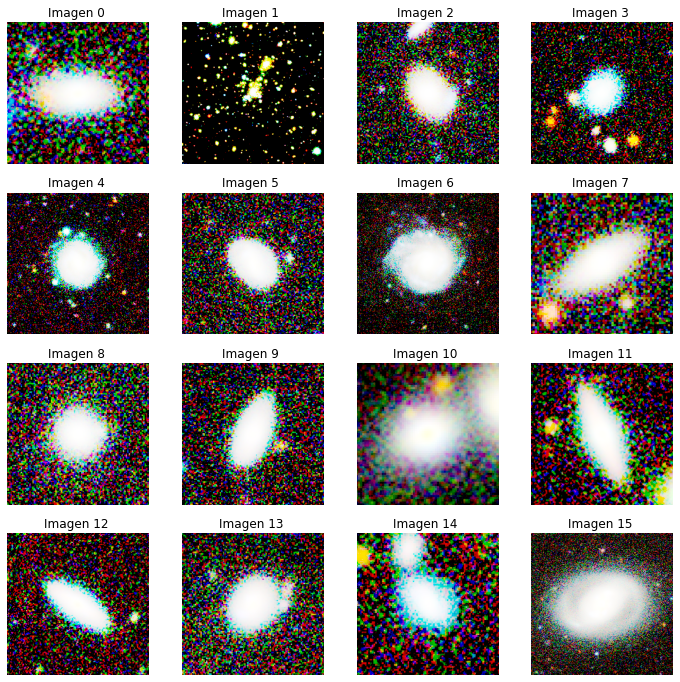

In [6]:
strategy = tf.distribute.MirroredStrategy()
ds_train = build_distributed_dataset(16, strategy)
image_batch, label_batch = next(iter(ds_train))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} '.format(i))
  plt.axis("off")

# Darker 0.15 + Autocontrast + Posterize con 5 bits

In [7]:
def preprocess_for_train(image, height, width, color_distort):
    
    image = darker(image, number=0.15)
    image = auto_contrast(image)
    image = posterize(image, bits=6)
        
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


def preprocess_image(image, height, width, color_distort=True):
  
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.central_crop(image, 0.65)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]
    return preprocess_for_train(image, height, width, color_distort)

/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


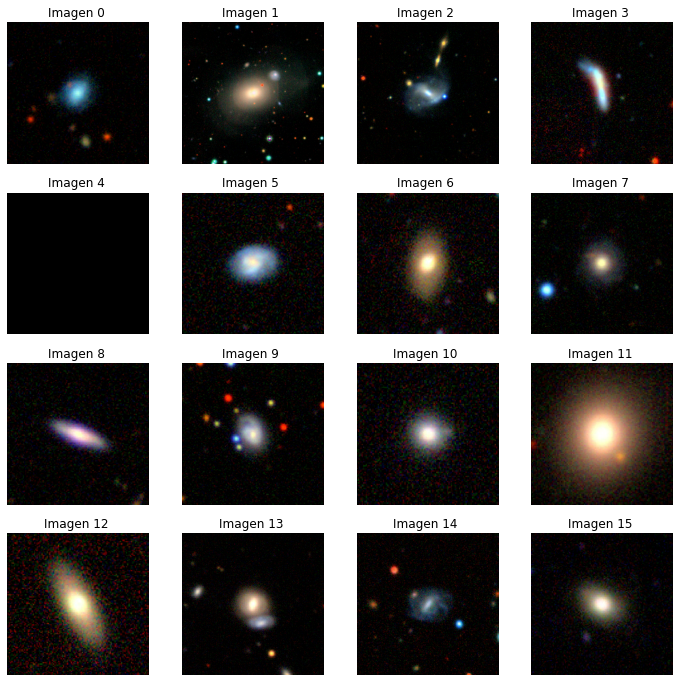

In [8]:
ds_train = build_distributed_dataset(16, strategy)
image_batch, label_batch = next(iter(ds_train))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} '.format(i))
  plt.axis("off")

In [9]:
# sharpness(image, magnitude)

In [10]:
def preprocess_for_train(image, height, width, color_distort):
    
    image = darker(image, number=0.15)
    image = auto_contrast(image)
    image = sharpness(image, magnitude=0.5)
    #image = invert(image)
    image = color(image, magnitude=0.5)
        
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


def preprocess_image(image, height, width, color_distort=True):
  
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.central_crop(image, 0.65)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]
    return preprocess_for_train(image, height, width, color_distort)

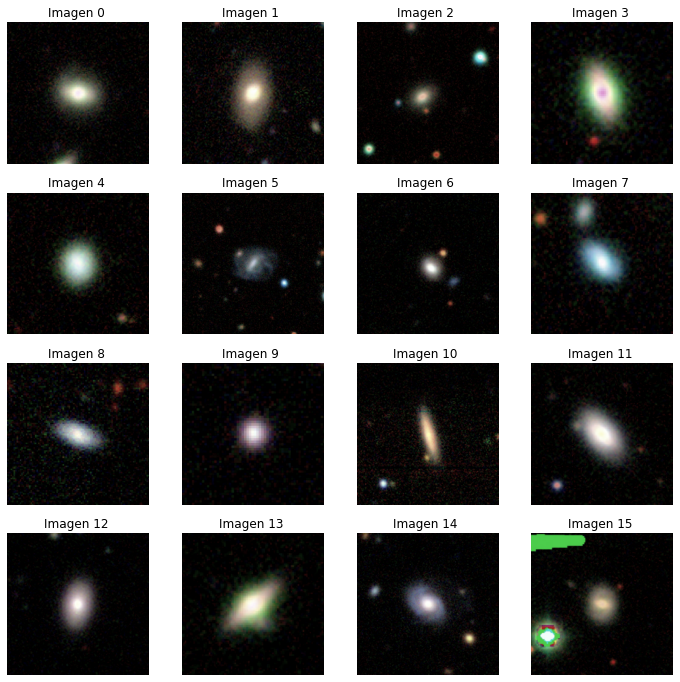

In [11]:
ds_train = build_distributed_dataset(16, strategy)
image_batch, label_batch = next(iter(ds_train))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} '.format(i))
  plt.axis("off")

In [12]:
def preprocess_for_train(image, height, width, color_distort):
    
    image = darker(image, number=tf.random.uniform([], -0.04, 0.19))#tf.random.uniform([], 0, 1.0))
        
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


def preprocess_image(image, height, width, color_distort=True):
  
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.central_crop(image, 0.65)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]
    return preprocess_for_train(image, height, width, color_distort)

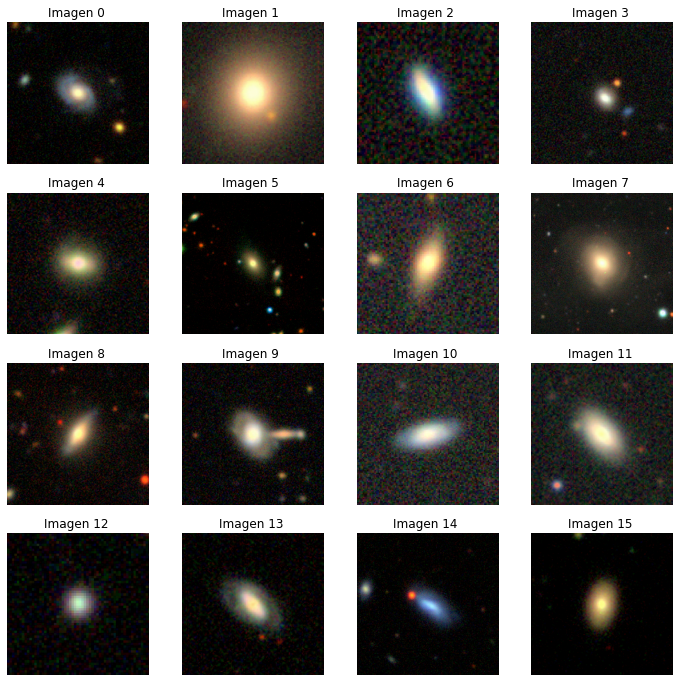

In [13]:
ds_train = build_distributed_dataset(16, strategy)
image_batch, label_batch = next(iter(ds_train))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} '.format(i))
  plt.axis("off")

In [14]:
def functions_rand(image):
    
    def apply_transform(i, x):
        
        #def invert_foo():
        #    return invert(x)
            
        #def solarize_foo():
        
        #    return solarize(x, tf.random.uniform([], 0, 1.0))
        
        def auto_contrast_foo():
            
            return auto_contrast(x)
            
        def color_foo():
        
            return color(x, magnitude = tf.random.uniform([], 0.2, 1.0))
            
        def sharpness_foo():
            return sharpness(x, magnitude = tf.random.uniform([], 0, 1.0))
            
        def posterize_foo():
            return posterize(x, bits = tf.cast(tf.random.uniform([], 4, 9), tf.int8))
            
        #def darker_foo():
        #    return darker(x, number=tf.random.uniform([], -0.04, 0.19))
        
        x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), auto_contrast_foo, color_foo),
                  lambda: tf.cond(tf.less(i, 3), sharpness_foo, posterize_foo))
        return x
    
    perm = tf.random.shuffle(tf.range(4))
    for i in range(4):
        image = apply_transform(perm[i], image)
        #image = tf.clip_by_value(image, 0., 1.)
    return image

In [15]:
def preprocess_for_train(image, height, width, color_distort):
    
    #rand = functools.partial(functions_rand)
    image = functions_rand(image)
    image = darker(image, number=tf.random.uniform([], 0, 0.19))
        
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


def preprocess_image(image, height, width, color_distort=True):
  
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.central_crop(image, 0.6)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]
    return preprocess_for_train(image, height, width, color_distort)

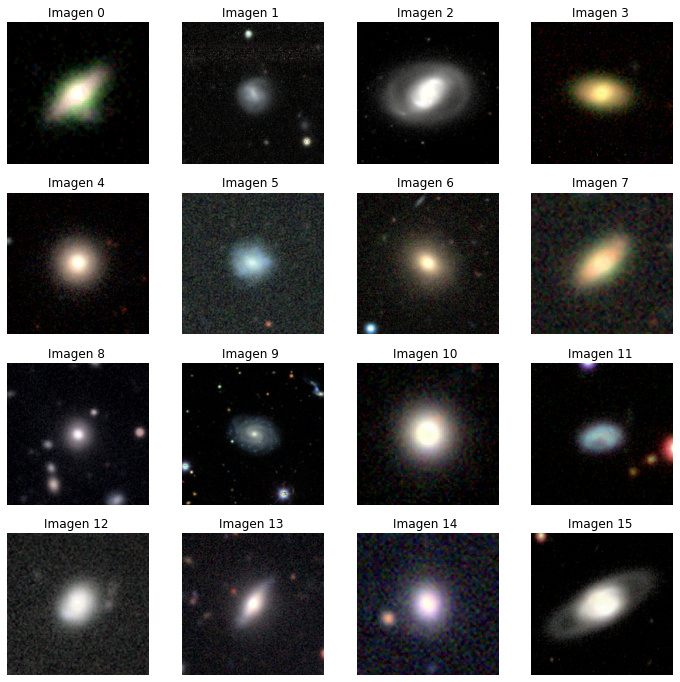

In [16]:
ds_train = build_distributed_dataset(16, strategy)
image_batch, label_batch = next(iter(ds_train))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} '.format(i))
  plt.axis("off")